In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
compas = pd.read_csv('data/compas-scores-two-years-violent.csv')
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


In [3]:
compas['c_jail_in'] = pd.to_datetime(compas['c_jail_in'], errors='coerce')
compas['c_jail_out'] = pd.to_datetime(compas['c_jail_out'], errors='coerce')

compas['v_screening_date'] = pd.to_datetime(compas['v_screening_date'], errors='coerce')
compas['vr_offense_date'] = pd.to_datetime(compas['vr_offense_date'], errors='coerce')

compas['c_offense_date'] = pd.to_datetime(compas['c_offense_date'], errors='coerce')
compas['c_arrest_date'] = pd.to_datetime(compas['c_arrest_date'], errors='coerce')

compas['compas_screening_date'] = pd.to_datetime(compas['compas_screening_date'], errors='coerce')


In [4]:
compas = compas.drop(['first','last','c_case_number','c_charge_degree', 'c_charge_desc', 'r_case_number','r_charge_degree','vr_case_number','vr_charge_degree','start','end','event'],axis=1)

#remove row with nan scores 
compas = compas.loc[compas['score_text'].notnull()]
#clean out the "-1" decile score from dataset 
compas = compas.loc[compas['v_decile_score'] != -1]

#label encodimg
compas['sex'] = compas['sex'].replace({'Male': 1, 'Female': 0})
compas['score_text'] = compas['score_text'].replace({'Low':0, 'Medium':1, 'High': 2})

#days in jail
compas['jail_out- jail_in'] = (compas['c_jail_out'] - compas['c_jail_in']).dt.days

In [5]:
compas.info()
df = pd.DataFrame(compas)
df.to_csv('./data/compas.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4738 entries, 0 to 4742
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       4738 non-null   int64         
 1   name                     4738 non-null   object        
 2   compas_screening_date    4738 non-null   datetime64[ns]
 3   sex                      4738 non-null   int64         
 4   dob                      4738 non-null   object        
 5   age                      4738 non-null   int64         
 6   age_cat                  4738 non-null   object        
 7   race                     4738 non-null   object        
 8   juv_fel_count            4738 non-null   int64         
 9   decile_score             4738 non-null   int64         
 10  juv_misd_count           4738 non-null   int64         
 11  juv_other_count          4738 non-null   int64         
 12  priors_count             4738 non-

In [6]:
compas.describe(include=["object","category"]).T

,count,unique,top,freq
name,4738,4716,anthony gonzalez,2
dob,4738,3973,1985-11-02,4
age_cat,4738,3,25 - 45,2698
race,4738,6,African-American,2266
r_offense_date,995,675,2016-03-01,5
r_charge_desc,972,196,Battery,192
r_jail_in,690,522,2014-02-18,5
r_jail_out,690,494,2013-11-13,5
vr_charge_desc,819,83,Battery,329
type_of_assessment,4738,1,Risk of Recidivism,4738


In [7]:
compas.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4738.0,5453.467919,3190.611730,1.0,2626.25,5474.5,8239.75,11000.0
sex,4738.0,0.789996,0.407354,0.0,1.00,1.0,1.00,1.0
age,4738.0,35.982693,12.187877,18.0,26.00,33.0,44.00,83.0
juv_fel_count,4738.0,0.045378,0.420913,0.0,0.00,0.0,0.00,20.0
decile_score,4738.0,3.983326,2.746394,1.0,1.00,3.0,6.00,10.0
juv_misd_count,4738.0,0.070916,0.406349,0.0,0.00,0.0,0.00,8.0
juv_other_count,4738.0,0.080836,0.469019,0.0,0.00,0.0,0.00,17.0
priors_count,4738.0,2.678767,4.085974,0.0,0.00,1.0,3.00,38.0
days_b_screening_arrest,4470.0,2.734452,78.116981,-345.0,-1.00,-1.0,-1.00,1057.0
c_days_from_compas,4727.0,72.760736,385.892451,0.0,1.00,1.0,2.00,9485.0


In [8]:
compas_race = compas['race'].value_counts()
compas_race

African-American    2266
Caucasian           1697
Hispanic             458
Other                279
Asian                 27
Native American       11
Name: race, dtype: int64

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'African-American'),
  Text(1, 0, 'Caucasian'),
  Text(2, 0, 'Hispanic'),
  Text(3, 0, 'Other'),
  Text(4, 0, 'Asian'),
  Text(5, 0, 'Native American')])

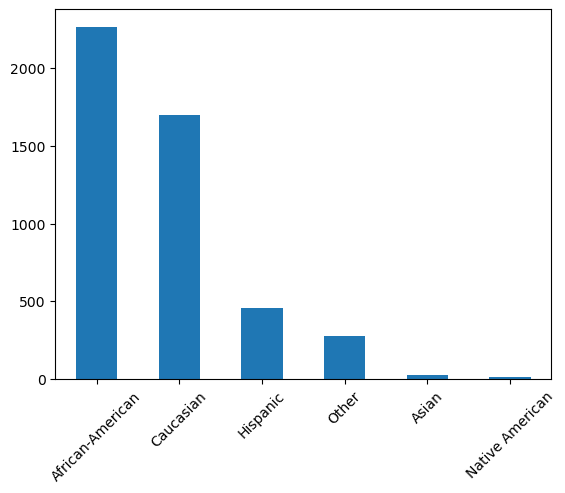

In [9]:
compas['race'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)

(array([0, 1, 2]),
 [Text(0, 0, '25 - 45'),
  Text(1, 0, 'Greater than 45'),
  Text(2, 0, 'Less than 25')])

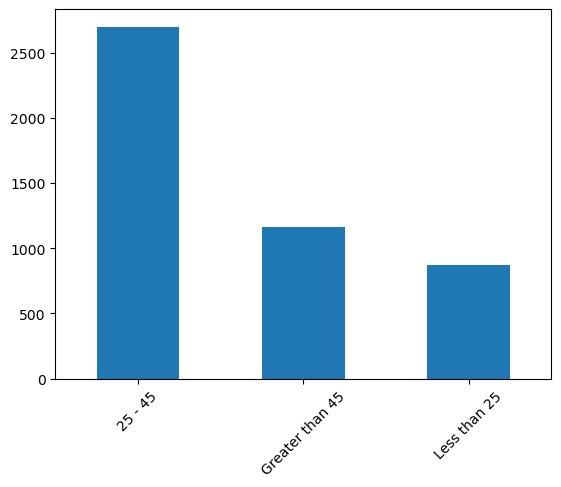

In [10]:
compas['age_cat'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)

In [11]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4738 entries, 0 to 4742
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       4738 non-null   int64         
 1   name                     4738 non-null   object        
 2   compas_screening_date    4738 non-null   datetime64[ns]
 3   sex                      4738 non-null   int64         
 4   dob                      4738 non-null   object        
 5   age                      4738 non-null   int64         
 6   age_cat                  4738 non-null   object        
 7   race                     4738 non-null   object        
 8   juv_fel_count            4738 non-null   int64         
 9   decile_score             4738 non-null   int64         
 10  juv_misd_count           4738 non-null   int64         
 11  juv_other_count          4738 non-null   int64         
 12  priors_count             4738 non-

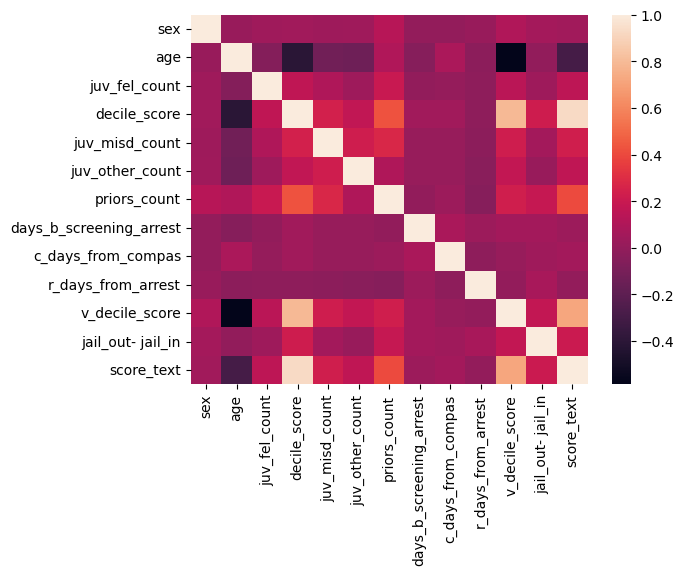

In [12]:
corr_matrix = compas[['sex', 'age','juv_fel_count', 'decile_score', 
                    'juv_misd_count','juv_other_count','priors_count', 
                    'days_b_screening_arrest', 'c_days_from_compas', 'r_days_from_arrest', 'v_decile_score', 'jail_out- jail_in','score_text' ]].corr()
sns.heatmap(corr_matrix, annot=False)
plt.show()

In [13]:
corr_matrix.style.background_gradient(cmap='coolwarm')

,sex,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,r_days_from_arrest,v_decile_score,jail_out- jail_in,score_text
sex,1.000000,0.015978,0.040816,0.047062,0.038976,0.044674,0.128021,-0.000275,-0.001769,0.018782,0.103403,0.062777,0.049109
age,0.015978,1.000000,-0.053960,-0.409487,-0.124261,-0.133774,0.103309,-0.050985,0.084579,-0.027548,-0.585066,-0.003244,-0.298658
juv_fel_count,0.040816,-0.053960,1.000000,0.158253,0.099670,0.035951,0.195420,-0.005982,0.007827,-0.019868,0.141345,0.038547,0.155856
decile_score,0.047062,-0.409487,0.158253,1.000000,0.238647,0.169850,0.428627,0.048097,0.050770,-0.020897,0.793656,0.214701,0.927137
juv_misd_count,0.038976,-0.124261,0.099670,0.238647,1.000000,0.221354,0.275389,0.013966,0.014319,-0.024064,0.224865,0.055069,0.231478
juv_other_count,0.044674,-0.133774,0.035951,0.169850,0.221354,1.000000,0.097052,0.011059,0.013208,-0.036326,0.174892,0.020226,0.163926
priors_count,0.128021,0.103309,0.195420,0.428627,0.275389,0.097052,1.000000,-0.007479,0.033486,-0.048443,0.228437,0.184356,0.400409
days_b_screening_arrest,-0.000275,-0.050985,-0.005982,0.048097,0.013966,0.011059,-0.007479,1.000000,0.081797,0.030270,0.056312,0.053822,0.030595
c_days_from_compas,-0.001769,0.084579,0.007827,0.050770,0.014319,0.013208,0.033486,0.081797,1.000000,-0.021617,0.010683,0.045778,0.056629
r_days_from_arrest,0.018782,-0.027548,-0.019868,-0.020897,-0.024064,-0.036326,-0.048443,0.030270,-0.021617,1.000000,-0.001250,0.073764,-0.002105


In [14]:
compas.head()

,id,name,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,two_year_recid,two_year_recid.1,jail_out- jail_in
0,1,miguel hernandez,2013-08-14,1,1947-04-18,69,Greater than 45,Other,0,1,...,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,0,0.0
1,3,kevon dixon,2013-01-27,1,1982-01-22,34,25 - 45,African-American,0,3,...,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,1,1,10.0
2,5,marcu brown,2013-01-13,1,1993-01-21,23,Less than 25,African-American,0,8,...,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,0,NaN
3,6,bouthy pierrelouis,2013-03-26,1,1973-01-22,43,25 - 45,Other,0,1,...,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,0,NaN
4,7,marsha miles,2013-11-30,1,1971-08-22,44,25 - 45,Other,0,1,...,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,0,0,1.0
